In [1]:
import sys
sys.path.append("/Users/A118390615/Library/CloudStorage/OneDrive-DeutscheTelekomAG/Projects/COE_Projects/CareerDevelopmentTool")

from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field, RootModel
from langchain_core.output_parsers import PydanticOutputParser, JsonOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langgraph.graph import MessagesState, StateGraph, START, END
from typing import TypedDict, Annotated, List
from langchain_core.messages import HumanMessage, AIMessage
import operator
import os
import numpy as np
from typing import Dict, List, Union, Optional, Literal
from enum import Enum
from langchain_openai import ChatOpenAI, AzureChatOpenAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from db_operations.utility_db import *

load_dotenv(override=True)

E0000 00:00:1761324400.837175 17331604 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761324400.840290 17331604 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


True

In [2]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0.)
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

E0000 00:00:1761324401.089902 17331604 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1761324401.090945 17331604 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [3]:
wordList = ["machine learning", "deep learning", "openai"]
jobRole = None
jobDescription = """
•	4+ years working experience as a software engineer, preferably in an enterprise and data science environment
•	A true team player who likes to contribute and benefit from working with others
•	Engineer capable of designing solutions, writing code, testing code, automating tests and deployment
•	Demonstrated skills, knowledge and expertise with statistical computer languages (Python, R, etc.) and the related ecosystem (PyCharm, Jupyter, …)
•	Strong experience working and creating data architectures to designing and developing mission critical enterprise grade software in a big data environment
•	Good knowledge of CI/CD and automated testing with Python
•	Creative problem-solving ability and sound judgment – ability to use own initiative and take responsibility for decisions
•	Strong spoken and written communication skills in English (German is a plus) combined with very strong client service orientation and willingness to travel
"""
experience = ">5 and <=8 Years"

In [4]:
data = refined_resume(wordList = wordList, jobRole = None, experience = experience)

WordList:  ['machine learning', 'deep learning', 'openai']
JobRole:  None
jobDescription:  None
Experience:  >5 and <=8 Years
2025-10-24 22:16:46 [info     ] Processing wordList:           details=['machine learning', 'deep learning', 'openai']
2025-10-24 22:16:46 [info     ] Processing experience:         details='>5 and <=8 Years'
2025-10-24 22:16:46 [info     ] Base SQL:                      details="select * from resume_store where (resume_raw_text ILIKE '%machine learning%' or resume_raw_text ILIKE '%deep learning%' or resume_raw_text ILIKE '%openai%') and get_yoe between 5 and 8"


In [5]:
def create_similarity_score(job_description_emb, recruiter_overview_emb):

    dot_product = np.dot(job_description_emb, recruiter_overview_emb)
    magnitude_jd = np.linalg.norm(job_description_emb)
    magnitude_ro = np.linalg.norm(recruiter_overview_emb)

    similarity_score = dot_product / (magnitude_jd * magnitude_ro)
    return similarity_score

In [6]:
name_list, recruiter_list, email_list, overview_list = [], [], [], []
for candidate in data:
    name_list.append(candidate['name'])
    overview_bullets = candidate['get_recruiters_overview']['bullets']
    overview_technical = candidate['get_recruiters_overview']['technical_proficiency']
    overview = overview_bullets + overview_technical
    overview_str = " ".join(overview)
    overview_list.append(overview_str)
    email_id = candidate['email_id']
    email_list.append(email_id)
    break

In [71]:
" ".join(overview)

'Enthusiastic professional targeting a Cybersecurity Analyst role with relevant expertise. Experienced in predictive modeling and text analytics using various AI techniques. Familiar with cloud services including AWS and Azure in analytical contexts. Proficient in implementing solutions using Python and SQL for data-driven projects. Skilled in deploying machine learning models and working with distributed frameworks. Strong experience in client collaboration to define project goals and outcomes. Proficiency in working with Machine Learning and NLP frameworks: - Developed predictive models for telecom and insurance sectors. - Applied generative AI for chatbot and service desk integrations. Cloud & Data Services / DevOps: - Utilized AWS services for model deployment and data storage. - Experience with Docker for containerization of applications. Languages, Frameworks & Databases: - Proficient in Python and Flask for building APIs and web applications. - Familiar with SQL and NoSQL databa

In [7]:
def refined_search_results(data, jobDescription, num_results=3):

    name_list, email_list, overview_list = [], [], []
    for candidate in data:
        name_list.append(candidate['name'])
        overview_bullets = candidate['get_recruiters_overview']['bullets']
        overview_technical = candidate['get_recruiters_overview']['technical_proficiency']
        overview = overview_bullets + overview_technical
        overview_str = " ".join(overview)
        overview_list.append(overview_str)
        email_id = candidate['email_id']
        email_list.append(email_id)

    overview_emb = embeddings.embed_documents(overview_list)
    jobDescription_emb = embeddings.embed_query(jobDescription)

    final_list = []
    for idx, name in enumerate(name_list):
        final_list.append([name, overview_list[idx], email_list[idx], float(round(create_similarity_score(jobDescription_emb, overview_emb[idx]), 3))])
        
    final_list.sort(key = lambda x: x[2], reverse=True)
    final_list = final_list[:num_results]
    final_df = pd.DataFrame(final_list, columns = ['name', 'overview', 'email_id', 'similarity_score'])

    # Get all the required data for candidates
    data_df = pd.DataFrame.from_records(data)
    df = pd.merge(final_df, data_df, on=['name', 'email_id'], how="left").to_dict("records")
        
    return df

In [8]:
if jobDescription is not None:
    results = refined_search_results(data, jobDescription, num_results=3)

In [17]:
candidate_prompt_list = []
for idx, candidate in enumerate(results):
    prompt = f"--BEGIN_CANDIDATE-{idx}--" + "\n"
    prompt += "Name: " + candidate['name'] + "\n"
    prompt += "Resume: " + candidate['resume_raw_text'] + "\n"
    prompt += f"--END_CANDIDATE={idx}--" + "\n"
    
    candidate_prompt_list.append(prompt)

In [23]:
from pydantic import BaseModel, Field, conint, confloat

class CandidateEvaluation(BaseModel):
    name: str = Field(..., description="Full name or candidate ID")
    rank: conint(ge=1) = Field(..., description="Rank of the candidate (1 = highest)")
    overall_score: confloat(ge=0, le=5) = Field(..., description="Overall weighted score between 0 and 5")
    justification: str = Field(..., description="2–3 point-wise sentences explaining why the candidate holds this rank and how well they align with the role")

class RankedCandidatesResponse(BaseModel):
    ranked_candidates: List[CandidateEvaluation] = Field(..., description="List of candidates ranked according to their evaluated fit for the job")

In [28]:
selection_prompt = """
You are a senior technical recruiter and hiring consultant with strong domain knowledge in evaluating resumes against a job description. Evaluate objectively, compare candidates critically, and return a concise, evidence-based shortlist. Use the rubric and output format exactly as specified. Do not invent facts — if a resume lacks explicit information, mark the item as "not stated". Maintain a professional, neutral tone.

Confidentiality: do not include personal contact details or sensitive PII; use only names or candidate IDs provided.

JOB DESCRIPTION:
<PASTE FULL JOB DESCRIPTION HERE — include role title, required skills, nice-to-have skills, years of experience, education, location/remote, responsibilities, seniority, and any mandatory certifications or domain experience.>

RESUMES:
{candidate_list}

1) Analyze the job description carefully. Identify:
   - Must-have (mandatory) skills and qualifications.
   - Nice-to-have or preferred skills.
   - Required years of experience and expected seniority.
   - Any deal-breakers or disqualifiers.

2) For each candidate, assess and score them on the following 3 dimensions using a 0–5 scale (integers only):
   - Core Technical Skills Match (weight 35%)
   - Relevant Domain/Industry Experience (weight 20%)
   - Years of Experience & Seniority Fit (weight 45%)

   Compute `overall_score` as the weighted average of the three dimensions, rounded to two decimal places.
   If any *mandatory* requirement is missing, mark `"Fail: mandatory requirement missing"` and assign an overall_score of 0.

3) Provide short *evidence snippets* from the resume for each dimension (max 20 words).  
   If information is absent, write `"not stated"`.

4) After evaluating all candidates:
   - Rank them in descending order by `overall_score` (highest = Rank 1).
   - Assign a fit category (bucket):
       * "Strong fit" — ≥ 4.0
       * "Good fit" — 3.0–3.99
       * "Consider with reservations" — 2.0–2.99
       * "Not recommended" — < 2.0 or fail flagged
   - Generate a concise justification (2–3 point-wise sentences) explaining **why** the candidate received that rank, summarizing strengths, alignment, and key missing areas.

5) Output **all 10 candidates** with:
   - Name  
   - Rank  
   - Overall score  
   - Justification  

6) Tie-breaking rules:
   - Prefer higher Core Technical Skills score.  
   - If still tied, prefer stronger Domain/Industry Experience.

7) **Output Format** — Must include:
   A) `ranked_candidates` JSON array:
      ```
      [{{
        "name": "<candidate name>",
        "rank": <integer>,
        "overall_score": <float 0–5>,
        "justification": "<2–3 point wise summary explaining why the candidate holds this rank and how well they align with the role>"
      }}]
      ```

8) Strict rules:
- Always include name, rank, overall_score, and justification for every candidate.
- Use short, factual evidence; no long text from resumes.
- Do not include personal details, assumptions, or commentary beyond evaluation.
"""

In [29]:
template = PromptTemplate.from_template(template=selection_prompt)
chain = template | llm.with_structured_output(RankedCandidatesResponse)
response = chain.invoke({"candidate_list": "\n".join(candidate_prompt_list)})

In [31]:
response.ranked_candidates

[CandidateEvaluation(name='Ketan Kishore', rank=1, overall_score=5.0, justification='Excellent alignment across all requirements, demonstrating strong hands-on experience in Generative AI, NLP, and end-to-end model deployment. Possesses over 6 years of relevant experience, perfectly matching the seniority level, and has worked across key domains including Telecom and Banking. Shows a complete skill set from development (Python, PySpark) to deployment (Flask, Docker), making him a top candidate.'),
 CandidateEvaluation(name='Jitendra Singh', rank=2, overall_score=4.55, justification='Exceptional technical skills, particularly in MLOps and production deployment using FastAPI, Docker, Jenkins, and Kubernetes. Strong project experience in Generative AI and NLP across relevant domains like insurance and banking. With 5.5 years of experience, he meets the required seniority and brings advanced deployment capabilities.'),
 CandidateEvaluation(name='Sagar Mokashi', rank=3, overall_score=4.25, 

In [78]:
pd.DataFrame(results)#['overview'].iloc[1]

,name,overview,email_id,similarity_score,job_role,mobile_number,get_yoe,get_ryoe,score_resume,get_contacts,...,get_other_comments,get_functional_constituent,get_technical_constituent,get_education,get_projects,get_company,get_location,get_designation,get_recruiters_overview,created_at
0,Sagar Mokashi,"7+ years of experience in the IT industry, tra...",sagar.mokashi1995@gmail.com,0.801,Backend Developer,"9987686276, 7021780449",7.3,3.3,{'items': ['Revise the resume title to reflect...,"{'color': 'green', 'comment': 'Both contact nu...",...,"{'title_match': {'score': 20, 'comment': 'The ...","{'industries': ['IT', 'Retail'], 'constituent'...","{'low': ['Kibana', 'Azure Synapse'], 'high': [...","[{'degree': 'B.E – IT', 'end_year': 'Not Speci...","{'projects': [{'color': 'light orange', 'score...",{'employment_history': [{'company': 'Accenture...,"{'location': 'India', 'confidence_score': 70}","{'current_designation': 'Data Scientist', 'pre...",{'bullets': ['7+ years of experience in the IT...,2025-10-22 05:21:27.171531+00:00
1,Ketan Kishore,Enthusiastic professional targeting a Cybersec...,ketan.kishore31@gmail.com,0.790,Cybersecurity Analyst,+91 7488391342,5.4,0.0,{'items': ['Update the job target from Data Sc...,"{'color': 'green', 'comment': 'Both contact nu...",...,"{'title_match': {'score': 50, 'comment': 'The ...","{'industries': ['Insurance', 'Banking', 'Telec...","{'low': ['Git', 'Selenium', 'Regex', 'Web Craw...","[{'degree': '10th', 'end_year': 2010, 'start_y...","{'projects': [{'color': 'light orange', 'score...",{'employment_history': [{'company': 'Capgemini...,"{'location': 'Bokaro Steel City, Jharkhand, In...","{'current_designation': 'Data Scientist', 'pre...",{'bullets': ['Enthusiastic professional target...,2025-10-21 17:37:30.733140+00:00
2,Jitendra Singh,5.5 years of experience focusing on Data Scien...,jitender1991rajput@gmail.com,0.792,Network Support Engineer,+91 7972507413,5.8,0.0,{'items': ['Resume lacks relevance to a Networ...,"{'color': 'green', 'comment': 'Both contact nu...",...,"{'title_match': {'score': 20, 'comment': 'Resu...","{'industries': ['Data Science', 'Education', '...","{'low': ['PostgreSQL', 'RedisDB', 'Mysql', 'Gi...","[{'degree': 'BSC (Mathematics)', 'end_year': 2...","{'projects': [{'color': 'light green', 'score'...",{'employment_history': [{'company': 'Nowrosjee...,"{'location': 'Pune, India', 'confidence_score'...",{'current_designation': 'Senior Data Scientist...,{'bullets': ['5.5 years of experience focusing...,2025-10-22 04:04:45.170320+00:00


In [52]:
df[df['name'] == 'Ketan Kishore']['get_recruiters_overview'].iloc[0]#['bullets']

{'bullets': ['Enthusiastic professional targeting a Cybersecurity Analyst role with relevant expertise.',
  'Experienced in predictive modeling and text analytics using various AI techniques.',
  'Familiar with cloud services including AWS and Azure in analytical contexts.',
  'Proficient in implementing solutions using Python and SQL for data-driven projects.',
  'Skilled in deploying machine learning models and working with distributed frameworks.',
  'Strong experience in client collaboration to define project goals and outcomes.'],
 'relevant_experience': 'Relevant Experience - 4+ years.',
 'technical_proficiency': ['Proficiency in working with Machine Learning and NLP frameworks:',
  '- Developed predictive models for telecom and insurance sectors.',
  '- Applied generative AI for chatbot and service desk integrations.',
  'Cloud & Data Services / DevOps:',
  '- Utilized AWS services for model deployment and data storage.',
  '- Experience with Docker for containerization of appli

In [49]:
df

,name,Overview,email_id,Similarity Score,job_role,mobile_number,get_yoe,get_ryoe,score_resume,get_contacts,...,get_other_comments,get_functional_constituent,get_technical_constituent,get_education,get_projects,get_company,get_location,get_designation,get_recruiters_overview,created_at
0,Sagar Mokashi,"7+ years of experience in the IT industry, tra...",sagar.mokashi1995@gmail.com,0.796,Backend Developer,"9987686276, 7021780449",7.3,3.3,{'items': ['Revise the resume title to reflect...,"{'color': 'green', 'comment': 'Both contact nu...",...,"{'title_match': {'score': 20, 'comment': 'The ...","{'industries': ['IT', 'Retail'], 'constituent'...","{'low': ['Kibana', 'Azure Synapse'], 'high': [...","[{'degree': 'B.E – IT', 'end_year': 'Not Speci...","{'projects': [{'color': 'light orange', 'score...",{'employment_history': [{'company': 'Accenture...,"{'location': 'India', 'confidence_score': 70}","{'current_designation': 'Data Scientist', 'pre...",{'bullets': ['7+ years of experience in the IT...,2025-10-22 05:21:27.171531+00:00
1,Ketan Kishore,Enthusiastic professional targeting a Cybersec...,ketan.kishore31@gmail.com,0.786,Cybersecurity Analyst,+91 7488391342,5.4,0.0,{'items': ['Update the job target from Data Sc...,"{'color': 'green', 'comment': 'Both contact nu...",...,"{'title_match': {'score': 50, 'comment': 'The ...","{'industries': ['Insurance', 'Banking', 'Telec...","{'low': ['Git', 'Selenium', 'Regex', 'Web Craw...","[{'degree': '10th', 'end_year': 2010, 'start_y...","{'projects': [{'color': 'light orange', 'score...",{'employment_history': [{'company': 'Capgemini...,"{'location': 'Bokaro Steel City, Jharkhand, In...","{'current_designation': 'Data Scientist', 'pre...",{'bullets': ['Enthusiastic professional target...,2025-10-21 17:37:30.733140+00:00
2,Jitendra Singh,5.5 years of experience focusing on Data Scien...,jitender1991rajput@gmail.com,0.819,Network Support Engineer,+91 7972507413,5.8,0.0,{'items': ['Resume lacks relevance to a Networ...,"{'color': 'green', 'comment': 'Both contact nu...",...,"{'title_match': {'score': 20, 'comment': 'Resu...","{'industries': ['Data Science', 'Education', '...","{'low': ['PostgreSQL', 'RedisDB', 'Mysql', 'Gi...","[{'degree': 'BSC (Mathematics)', 'end_year': 2...","{'projects': [{'color': 'light green', 'score'...",{'employment_history': [{'company': 'Nowrosjee...,"{'location': 'Pune, India', 'confidence_score'...",{'current_designation': 'Senior Data Scientist...,{'bullets': ['5.5 years of experience focusing...,2025-10-22 04:04:45.170320+00:00


In [ ]:
final_list = []
for idx, name in enumerate(name_list):
    final_list.append([name, overview_list[idx], round(create_similarity_score(jobDescription_emb, overview_emb[idx]), 3)])
    
#final_list.sort(key = lambda x: x[2], reverse=True)

In [29]:
final_list.sort(key = lambda x: x[2], reverse=True)

In [30]:
final_list

[['Jitendra Singh',
  '5.5 years of experience focusing on Data Science and Machine Learning projects. Adept at developing APIs using FastAPI and Flask frameworks. Skilled in deploying solutions using Docker and Kubernetes. Experience in optimizing CI/CD pipelines with Jenkins for streamlined deployments. Proficient in data extraction and manipulation using SQL databases. Expert in implementing machine learning models with Python for predictive analytics.',
  np.float64(0.819)],
 ['Sagar Mokashi',
  '7+ years of experience in the IT industry, transitioning into Backend Development. Proven experience in Python and machine learning for data-driven solutions. Developed sophisticated data analysis tools leveraging Generative AI for customer insights. Experience implementing clustering models for retail store performance enhancement. Skilled in Natural Language Processing with projects integrating sentiment analysis. Recognized with multiple awards for excellence in service and commitment.'

In [ ]:
np.

In [ ]:

for idx, name in enumerate(name_list):
    technical_overview_emb = overview_emb[idx]
    technical_overview = overview_list[idx]

NameError: name 'overview_emb' is not defined

In [16]:
embeddings.embed_documents(overview_list)

[[0.00027514234534464777,
  0.018333639949560165,
  0.008660546503961086,
  -0.07846825569868088,
  -0.014194211922585964,
  0.00031518758623860776,
  0.002222079550847411,
  0.0029865342658013105,
  -0.004334160126745701,
  0.0024157394655048847,
  0.004541953559964895,
  -0.010620662942528725,
  0.010625289753079414,
  0.03146057203412056,
  0.10722407698631287,
  -0.006220619659870863,
  -0.004196823108941317,
  -0.007606423459947109,
  0.020130621269345284,
  0.0028202272951602936,
  -0.004759215284138918,
  0.02721630409359932,
  -0.01923319697380066,
  -0.020255260169506073,
  0.0009955799905583262,
  -0.014040554873645306,
  0.028731057420372963,
  0.012735454365611076,
  0.03234744071960449,
  0.006496379151940346,
  -0.016377585008740425,
  0.008273276500403881,
  0.010646804235875607,
  0.041582703590393066,
  -0.004640647675842047,
  -0.0020844917744398117,
  0.016052590683102608,
  -0.01313749235123396,
  0.016414791345596313,
  0.012935459613800049,
  -0.005798998288810253

In [11]:
overview_list

[['Enthusiastic professional targeting a Cybersecurity Analyst role with relevant expertise.',
  'Experienced in predictive modeling and text analytics using various AI techniques.',
  'Familiar with cloud services including AWS and Azure in analytical contexts.',
  'Proficient in implementing solutions using Python and SQL for data-driven projects.',
  'Skilled in deploying machine learning models and working with distributed frameworks.',
  'Strong experience in client collaboration to define project goals and outcomes.'],
 ['5.5 years of experience focusing on Data Science and Machine Learning projects.',
  'Adept at developing APIs using FastAPI and Flask frameworks.',
  'Skilled in deploying solutions using Docker and Kubernetes.',
  'Experience in optimizing CI/CD pipelines with Jenkins for streamlined deployments.',
  'Proficient in data extraction and manipulation using SQL databases.',
  'Expert in implementing machine learning models with Python for predictive analytics.'],
 

In [31]:
jobRole = "Data Scientist"
resume_string_1 = """
ketan.kishore31@gmail.c  om  +91 7488391342  House No. 4098, Sector   –  4/F, Bokaro Steel City,  Jharkhand   -   827004  EDUCATION  10th from Delhi Public  School, Bokaro Steel City,  Jharkhand in 2010 with  95% GPA  12 th   from Delhi Public  School, Bokaro Steel City,  Jharkhand in 2013 with  82% GPA  B .Tech. in Electronics and  Communication from SRM  University, Chennai in 2017  with 76.85 GPA  M.Tech in Data Science and  Engineering from BITS   -  Work Integrated, 2023 with  7.27 CGPA  Ketan Kishore  An enthusiastic & high energy driven professional ,   targeting challenging assignments as a   Data  Scientist   with an organization of high repute .  GitHub Repo:   https://github.com/ketankishore27  Docker Hub Repo:   https://hub.docker.com/u/ketankishore27  LinkedIn :   https://www.linkedin.com/in/ketan - kishore - b89643150/  PROFILE SUMMARY  •   Goal - oriented professional with experience in   Insurance ,   Banking , and   Telecom   domains.  •   Skilled in   Predictive Modeling   using   Supervised   and   Unsupervised   Learning  •   E xperienced in   Text   Analytics   using   NLP , LLM   and   Generative AI  •   Exposure   to   Cloud services like   AWS   and   Azure  •   Proficient   in working with   Distributed Framework   for   scalable   Analytics and Modelling  PROJECTS  T - Systems India Pvt Ltd   Apr’21   –   Present  Client:   Deutsche Telekom (Germany)  Common Service Desk   (Generative AI)  •   Partnered with stakeholders to define clear project goals and success criteria .  •   Designed and implemented backend models for service desk   support   using RASA and RAG .  •   Fine - tuned model responses to enhance accuracy and   user experience .  •   Created   APIs   for real - time AI model integration .  •   Analysis for incorrect responses from the chatbot.  Client:   Deutsche   Telekom   ( Germany,   Croatia , Hungary , Poland )  Router Domain   (Machine Learning, Big Data)  •   Feature store for telecom data .  •   Developed   models to predict   issues   like   Device, I nstallation , Line, Wi - Fi   error etc.  •   D ashboards   for the bootstrapped new router   developed by   organization .  •   Created flows to   troubleshoot and find new issues in new router versions.  •   Developed customer profiling and journey analysis for people visiting our app.  •   Helped in   finding out issues in the Deutsche Telecom `My Magenta` app  Bajaj Finance   Jun ’ 20   –   Apr’21  Client: Loans /Lending   Team  Money Manager   (Machine Learning)  •   Created ML model to   classify   transactional message   and store entities  •   Assisting   in creating real time offer generation pipeline based on above extracted entities  Client: E - Store   Team  Nearest Dealer Solution   (Machine Learning)  •   Created a   ML model to identify   nearest dealers   for   visitors   on the website.  •   Incorporated business rules to recommend dealers based on loyalty, reviews/score and distance  Client: Marketing   + Cards Team  Clickstream Analytics   (Adobe Analytics, Big Data)  •   Created reports on   Adobe Analytics   on Customer Journey, Path, Churn and Anomaly  •   A nalyze and   r ecommend concordan t /discordan t   simulations sent to the identified visitors
PERSONAL DETAILS  Date of Birth: 20 th   February 1995  Lan guages Known: English and Hindi  HOBBIES  •   Travel  •   Cook  •   Gym  •   Personal Projects ( Here )  •   Friends Catchup  Capgemini.   Oct ’ 17   -   Jun ’20  Client:   Swiss Re  Trip Optimization   -   POC (Tableau, Statistical Modelling)  •   Developed a constrained   algorithm   to optimize trip allocation   cost .  •   Implemented hierarchical de - allocation of trips consi dering corporate band and real time  Tableau frontend filters  •   Created and presented   dashboard having   Drill Down Reports   and overall summary  Client:   Sunlife Financials  News - Feed   –   POC   (N atural   L anguage   P rocessing , Web Scraping)  •   Developed a web crawler   to search   the web   and perform NLP task to create insights.  •   Worked   on possibility to use   satellite imagery to predict Catastrophes damage index .  Client:   Assurant Employee Benefits  Analytics   and Automation   (Python, Basic Machine Learning)  •   Analyze ,   Visualize,   and deduce KPI based on claims distributed over geographical area.  •   Implemented ML and DL model to predict   Fraudulent/Incorrect C laims  •   Work ed   parallel   on   development of   Churn Model   ( POC ).  •   Created   Python API’s and Selenium automations
"""

resume_string_2 = """
RAVI PRABHAKAR
+91-9920036707/9321236707
Project Manager (AGM, Automation Process Management)
ravi.pbkr@gmail.com
Pursue opportunities as a Digital Transformation Leader, bringing expertise in spearheading innovative initiatives in Network
Operations & Robotic Process Automation (RPA) while improving business processes & operational efficiency across various sectors.
PROFILE SUMMARY
 Strategic Digital Transformation Leader with over 17 years of experience driving innovation and leading end-to-end
automation initiatives, optimizing network operations, and transforming RPA workflows to enhance operational efficiency and
deliver substantial cost savings across large-scale global projects.
 Project Management Expertise in managing complex digital transformations, delivering cloud-based solutions (AWS) and
orchestrating the end-to-end project lifecycle from planning to execution, ensuring seamless integration, operational excellence,
and client satisfaction while driving cost-effective solutions.
 Stakeholder Engagement & Leadership: Adept at managing cross-functional teams, aligning stakeholders across diverse
geographies, and leveraging strategic thinking to mitigate project risks, resolve issues proactively, and maintain alignment with
business objectives and client expectations.
 Expertise in service delivery excellence through continuous process audit, quality assurance, and compliance management
(ISO 27000/20000), ensuring high-quality deliverables in alignment with SLAs and business standards, while overseeing project
schedules, budgets, and change management.
 Data-Driven Decision Maker, leveraging deep insights from network tools (VFO, ArcGIS, TEOCO) and cloud technologies to
identify cost-saving opportunities & optimize operational performance, ensuring the sustainability & growth of client businesses.
 Trained PMP and Certified Scrum Master, with expertise in agile methodologies and DevOps practices, empowering high-
performance teams to deliver impactful results, accelerate time-to-market, & maximize business value across the telecom & IT
services sectors.
CORE COMPETENCIES
 Digital Transformation
 Project Management
 Process Optimization
 Stakeholder Engagement
 Risk Management Framework
 Quality Assurance Protocols
 Cloud Solutions
 Change Management
 Service Delivery Excellence
 Project Lifecycle Management
 Operational Efficiency Metrics
 RPA Automation
 Client Relationship Management
 Network Operations
EDUCATION
 B.E. in Electronics and Telecommunication Engineering from Mumbai University | 2007
CERTIFICATIONS
 ITIL V3 || Prince2 Practitioner || CSM (Certified Scrum Master) || DevOps Engineer
TECHNICAL SKILLS
 Project Management:
 Cloud & Automation:
 OSS Tools:
 BSS Tools:
 Design & Network Tools:
: PMP Trained, Microsoft Project
: AWS, Python, RPA (AA, Blue prism)
: VFO, Kleiman, ADW, Clarity, ArcGIS, EFMS
: TEOCO, Granite, ATOS, BMP, ASOC, USRP
: MS Visio, Clarity, ArcGIS
SOFT SKILLS
 Leadership & Team Management || Decision-Making || Communication & Interpersonal Skills || Collaboration & Cross-Functional
Coordination || Adaptability & Resilience || Attention to Detail || Strategic Communication
WORK EXPERIENCE
Nov’21 – Present | Project Manager (AGM, Automation Process Management) | Vodafone Idea Ltd.
Key Result Areas:
 Driving Process Automation: Leading 200+ automated processes, saving 100+ FTEs and 200 man-hours, with 30 more projects
expected to save 50+ FTEs.
 Managing Projects: Overseeing projects, integrating resources with expertise for successful delivery.
 Aligning Stakeholders & Mitigating Risks: Managing scope, risks, & conflicts while ensuring stakeholder alignment &
preventing delays.
 Leading High-Performing Teams: Building and guiding teams, defining roles & ensuring accountability for seamless execution.
 Budget & Timeline Oversight: Monitoring budgets & schedules, implementing corrective actions to ensure timely, cost-effective
delivery.
 Tracking & Reporting Progress: Acting as the primary contact for project updates, addressing risks & ensuring smooth execution.
 Risk Forecasting & Issue Resolution: Proactively identifying risks, mitigating challenges, and keeping projects on track.
 Project Scheduling & Planning: Developing & maintaining structured project schedules & comprehensive plans for successful
execution.
 Stakeholder Communication & Status Reporting: Providing clear updates, adapting strategies to evolving requirements, and
ensuring transparency.
 Change & Quality Management: Managing scope & resource changes while ensuring quality control for high-standard deliverables.
 Cross-Functional Collaboration: Encouraging teamwork and leveraging diverse expertise to drive innovation and efficiency.
 Post-Project Evaluation: Conducting reviews, sharing insights, and improving future project execution.
 Audit & Compliance Oversight: Leading ISO 27000 & ISO 20000 audits, ensuring adherence to industry standards.
Jul’14 – Oct’21 | Project Manager | Accenture Solutions (Region – USA-Remote)
Key Result Areas:
 Developed Service Portfolio: Created a comprehensive cloud, network, and Ethernet service portfolio for 50+ IT enterprises.
 Achieved Cost Savings & Managed SLA: Secured $500K–$1M in savings by managing SLA penalties, enhancing client profitability.
 Led Team & Managed Project Lifecycle: Led a team, overseeing the full project lifecycle from planning to deployment.
 Client Collaboration & Cost Optimization: Analyzed client requirements and identified cost-saving opportunities aligned with
business goals.
 Delivered Customized Solutions: Designed and deployed tailored product solutions, improving service offerings.
 Cultivated Client Relationships: Strengthened client relationships, minimizing escalations and driving business value.
 Refined Business Models: Provided data-driven insights to optimize business models and improve product performance.
 Provided Transparent Reporting: Delivered consistent status updates to both on-site and offshore leadership.
 Developed Cost-Saving Strategies: Identified and implemented cost-saving opportunities through data analysis.
 Ensured Client Satisfaction: Fostered strong client relationships by addressing needs and ensuring high satisfaction.
PREVIOUS EXPERIENCE
Apr’13 – Jun’14 | Deputy Manager | Alcatel Lucent Managed Solutions
Feb’11 – Mar’13 | Deputy Manager | Reliance Communication
Jul’09 – Jan’11 | SDH Engineer | Tulip Telecom
Jan’08 – Jun’09 | Trainee Engineer | Ericsson India (Off-role)
"""
resume_string_3="""
Harsh Kumar
Bangalore, KA +91 9142780129 harshsingh94636@gmail.com harshkumar Document Repository
Education
M.S. Ramaiah Institute of Technology Bachelor of Engineering• CGPA: 7.58 Delhi Public School Bokaro, JH
Senior Secondary (Class XII)• 88.8% DAV Public School Ranchi, JH
Secondary Education (Class X)• 90.8% Bangalore, KA
Dec 2022 – Sep 2026
Jul 2020 – Jul 2022
April 2019 – June 2020
Relevant Coursework
• Data Cleaning
• EDA
Experience
• SQL for Data Extraction
• Data Visualization
• BI Reporting
• Statistical Testing
• Predictive Analytics
• Python for Data Analysis
House Sutra Llp December 2024 – May 2025
Data Analyst Intern Jaipur, RJ
• Led analysis of large customer data sets to extract insights, directly influencing business strategy and improving
conversion rates by 20%.
• Designed and automated analytical dashboards (Excel, SQL, Python, Power BI) to track key operational metrics,
reducing manual reporting time by 30%.
• Managed and tracked multiple initiatives, creating analytical reports and progress dashboards for leadership review.
Tata Steel Ltd. September 2024 – October 2024
Data Analyst Intern Jamshedpur, JH
• Successfully conducted data cleaning and feature extraction,including parsing motor descriptions and normalizing key
performance metrics.
• Developed predictive maintenance strategies using SAP data,reducing downtime and maintenance costs.
• Identified performance trends and anomalies through temperature and pressure variation analysis using advanced
statistical methods.
Projects
Sales Data Visualization and Automation Tools: Power BI, Excel, Python
• Streamlined sales data analysis by first identifying key trends and top-performing products in Excel, then automating
data cleaning and summarization using Python (Pandas, NumPy, Matplotlib) to ensure accurate insights.
• Developed interactive Power BI dashboards from the processed data, enabling real-time sales performance monitoring
for House Sutra’s leadership and reducing manual reporting time by 35%.
Areas of Expertise
• Technical Skills: Advanced SQL, Python (Pandas, Numpy, Matplotlib), Advanced Excel, Power BI, Tableau.
• Tools & Platforms: MySQL, PyCharm, Microsoft Office Suite, VScode.
• Soft Skills: Cross-functional teamwork, Analytical Thinking, Problem Solving, Strong verbal & written
communication, Exceptional organisational skills, Interpersonal skills.
Research / Publications
Innovative Facility Layout [Presented: IPDIMS on 4th and 5th December,2024 @ NIT Rourkela]
Co-Author Ramaiah Institute of Technology
• Analyzed industrial workflows through site visits, documenting processes and mapping interdepartmental relationships.
Translated qualitative ratings (A, E, I, O, U, X) into quantitative values (6–1) for optimized layout analysis.
Certifications / Achievements
1. Google Data Analytics – Google: Practical skills in SQL, spreadsheets, Tableau, R, Data Preparation, Data
Wrangling, Root Cause Analysis, Business Intelligence Reporting, .
2. Python For Everybody – University of Michigan: Python scripting, data transformation.
3. SQL 50 – LeetCode: Hands-on practice with complex SQL queries, filtering, aggregation, Advanced joins.
4. Techno Vision Case Study: Secured 1st position at Techno 2025 awarded Rs 8,000 cash prize for
outstanding performance.
"""

In [74]:
def designation_extractor():

    class DesignationResponse(BaseModel):
        current_designation: Optional[str] = Field(None, description="The candidate's most recent or current job title. Null if not found.")
        previous_designation: Optional[str] = Field(None, description="The candidate's immediate past job title before the current one. Null if not found.")

    
    designation_output = PydanticOutputParser(pydantic_object=DesignationResponse).get_format_instructions()
    
    instruction_format = """
    You are an expert resume parser.

    Goal: From the provided resume text, extract the candidate’s CURRENT and PREVIOUS designation **together with the organization**, formatted exactly as:
        "Job Title at Organization"
    Return only JSON as specified at the end.
    
    Input placeholder:
    {resume_string}
    
    —— INSTRUCTIONS ——
    Think step-by-step internally and follow these rules exactly. Do NOT output your internal reasoning — only the final JSON.
    
    1) Locate the Experience section(s)
       - Search for sections titled: Experience, Work Experience, Professional Experience, Employment History, Career History, Roles, or similar.
       - Also consider company-by-company blocks, project headers that indicate employer/client, and any line that pairs a title with a company.
    
    2) Extract candidate entries
       - For each employment entry capture:
         • job title / designation (exact text as written; preserve capitalization and words, but normalize extra whitespace)
         • organization / company name (prefer the company-level name; use client name only if company name is absent)
         • start and end dates if available (e.g., "Oct 2017", "Apr’21", "2019–2020", "Present/Currently")
         • employment type if present (e.g., "Intern", "Contract", "Full-time", "Permanent", "Freelance")
       - Ignore purely academic projects, coursework, and certifications unless they are explicitly labeled as employment (e.g., "Research Intern", "Teaching Assistant", "Consultant at ...").
    
    3) Normalize dates for ordering
       - Parse common date formats and normalize to YYYY-MM-DD for sorting:
           • month+year → YYYY-MM-01 (e.g., "Oct 2017" → 2017-10-01)
           • year-only → YYYY-07-01 (use mid-year as proxy)
           • "Present", "Current", "Ongoing" → 2025-09-01 (use this fixed date)
       - If an entry has start date but no end date → treat end as 2025-09-01.
       - If no dates anywhere for an entry → fall back to document order (top-most entries are most recent).
    
    4) Rank entries by recency
       - Primary: any entry with end date = Present/Current (treat these as most recent).
       - Otherwise sort entries by end date descending; if end dates tie or missing, sort by start date descending.
       - If still ambiguous, prefer the entry that appears earlier (higher) in the Experience section (assume top-down recency).
    
    5) Resolve concurrent/ambiguous current roles
       - If multiple "Present" roles exist:
           • Prefer full-time/permanent over contract, freelance, or internship.
           • If multiple full-time, prefer the one with higher seniority keywords in the title (e.g., Principal > Lead > Head > Senior > Manager > Engineer > Associate > Junior).
           • If still tied, choose the one that appears first in the resume.
       - If a role is explicitly labeled as "Consultant" or "Freelance" and there's a full-time "Present" role, prefer the full-time role as CURRENT.
    
    6) Select CURRENT and PREVIOUS designations
       - CURRENT = the job title + " at " + organization of the most recent ranked employment entry.
       - PREVIOUS = the job title + " at " + organization of the next most recent employment entry (after removing the CURRENT entry).
       - If only one employment entry exists → CURRENT = that entry, PREVIOUS = null.
       - If no employment entries found → both CURRENT and PREVIOUS = null.
    
    7) Formatting rules for the returned strings
       - Output exactly: "<Job Title> at <Organization>"
       - If organization is missing but title is present → return just "<Job Title>" (no "at").
       - If title is missing but organization present → return null for that slot.
       - Trim leading/trailing whitespace and collapse multiple internal spaces to single spaces.
       - Preserve original punctuation and capitalization from the resume (except whitespace normalization).
    
    8) De-duplication and client/project blocks
       - If a single employer block contains multiple client-project sub-roles, prefer the top-level employer position as the designation (e.g., "SDE at ACME Corp" rather than "Project: QA for ClientX").
       - If the resume lists the same title at the same employer multiple times (e.g., contract renewals), treat them as one continuous role for ordering.
    
    9) Exclusions
       - Do NOT extract job descriptions, bullet points, or project titles as designations.
       - Do NOT include internship/course titles unless explicitly listed as employment.
       - Do NOT invent company names or titles.
    
    —— END ——
    
    Now parse the input and produce the results.
    
    Output format:
    {output_format}
    """

    prompt = PromptTemplate.from_template(template=instruction_format, 
                                          partial_variables={
                                              "output_format": designation_output
                                          })

    chain = prompt | llm | JsonOutputParser()

    return chain

In [75]:
designation_extractor_chain = designation_extractor()

In [76]:
designation_extractor_chain.invoke({"resume_string": resume_string_1})

{'current_designation': 'Data Scientist at T - Systems India Pvt Ltd',
 'previous_designation': 'Data Scientist at Bajaj Finance'}

In [50]:
def extract_location():

    class CandidateLocation(BaseModel):
        location: str = Field(..., description="Predicted location of the candidate (city/state/country)")
        confidence_score: float = Field(..., ge=0, le=100, description="Confidence score of the predicted location between 0 and 100")

    location_format = PydanticOutputParser(pydantic_object = CandidateLocation).get_format_instructions()

    instruction_format = """
    You are an expert in analyzing resumes and extracting candidate information.

    Your task is to deduce the **candidate’s location** from the provided resume text and assign a **confidence score (0–100)** for your prediction.
    
    ---
    
    ### Step-by-Step Reasoning Process:
    
    1. **Identify the Most Recent Job**  
       - Look for the candidate’s latest job experience.  
       - If a company and location are mentioned, take this as the primary hint.  
    
    2. **Check Personal/Contact Information**  
       - Scan the top section of the resume for addresses, cities, states, or countries.  
       - If this matches or complements the most recent job location, increase confidence.  
    
    3. **Analyze Education Section**  
       - If no recent job is available, check the location of the candidate’s most recent education institution.  
    
    4. **Cross-Reference Other Clues**  
       - Phone number country codes, email domains, LinkedIn profiles, or project client regions may hint at location.  
    
    5. **Resolve Ambiguities**  
       - If multiple locations are found, choose the one most closely tied to the **most recent professional or educational activity**.  
    
    6. **Assign Confidence Score**  
       - **80–100 (High confidence):** Location explicitly stated in recent job.  
       - **50–79 (Medium confidence):** Location inferred from education or older jobs.  
       - **0–49 (Low confidence):** Ambiguous or no strong evidence; best guess.  
    
    ---
    
    ### Input:
    **Resume Text:**  
    {resume_string}
    
    ---

    **Output format:**
    {output_format}
    """

    prompt = PromptTemplate.from_template(template = instruction_format,
                                          partial_variables={
                                              "output_format": location_format
                                          })
    
    chain = prompt | llm | JsonOutputParser()

    return chain

In [51]:
location_chain = extract_location()

In [52]:
location_chain.invoke({"resume_string": resume_string_1})

{'location': 'Bokaro Steel City, Jharkhand, India', 'confidence_score': 90}

In [29]:
def extract_recruiters_overview():

    class RecruiterOverview(BaseModel):
        bullets: List[str] = Field(description="List of recruiter-friendly bullet points summarizing the candidate's skills, experience, and traits.")
        relevant_experience: str = Field(description="A line summarizing the candidate’s relevant years of experience.")
        technical_proficiency: List[str] = Field(description="Detailed technical proficiencies, grouped by technology or domain area.")

    overview_format = PydanticOutputParser(pydantic_object=RecruiterOverview).get_format_instructions()
    
    instruction_format = """
    You are an expert recruiter-assistant and resume summarizer.  
    Input placeholders (replace with actual values before sending):
    - Target job role: "{job_role}"
    - Resume text: {resume_string}
    - Current date (for "Present"): {current_date}
    
    GOAL:
    Produce a concise, recruiter-style overview of the candidate that follows the example format exactly (top profile bullets, blank line, "Relevant Experience - X+ years.", then technology/competency sections with nested bullets). The overview must be evidence-first (only assert what the resume supports) and formatted exactly as described below.
    
    IMPORTANT OUTPUT RULES (MUST FOLLOW EXACTLY):
    - Output ONLY the overview text (no reasoning, no timelines, no JSON, no code fences, no extra commentary).
    - Use the bullet character "•" for top-level profile bullets.
    - Use the hyphen "-" for nested bullets inside technology/competency sections.
    - Provide exactly 6–10 top profile bullets (each starting with "•"), then one blank line, then the single line: `Relevant Experience - X+ years.`, then competency sections (headers + "-" bullets).
    - Each top-level bullet should be 8–20 words where possible, concise and evidence-based.
    - Do NOT include raw dates, timeline calculations, or internal processing steps in the output.
    - If NO professional experience is found, output exactly:
      • No professional experience found.
      
      Relevant Experience - 0+ years.
      (and then stop — no further sections)
    
    INTERNAL EXTRACTION & CALCULATION STEPS (THINK THESE STEPS, DO NOT OUTPUT THEM):
    1) Extract Employment Spans
       - Identify all professional roles: full-time, part-time, contract, freelance/consulting count as experience.
       - Exclude: internships, academic projects, coursework unless explicitly stated as post-graduation full-time employment.
       - Parse messy date formats (e.g., "Oct’17", "Apr'21", "2017–2020", "Present").
       - Normalize dates:
         • month+year → use the 1st of that month (e.g., Oct 2017 → 2017-10-01).
         • year-only → use July 01 of that year (e.g., 2017 → 2017-07-01).
         • "Present" or missing end → use {current_date}.
         • If only a start exists, end = {current_date}.
       - Discard employment spans clearly during education unless explicitly professional post-graduation.
    
    2) Compute Overall and Relevant Experience
       - UNION all normalized employment spans to get unique months → overall months → overall_years = months / 12.
       - Build relevance signals for {job_role}:
         • Title exact/close matches (including synonyms) → strong signal.
         • Role bullets containing ≥2 strong signals (tools, methods, domains, deliverables) → strong signal.
         • Strong signals are explicit mentions such as domain names, technologies, frameworks, methods, or common role verbs (e.g., "predictive modeling", "Spark", "NLP", "LLM", "ETL", "FastAPI", "BigQuery").
         • If ambiguous, default to NOT relevant unless ≥2 strong signals exist.
       - UNION spans flagged RELEVANT → relevant_months → ryoe = relevant_months / 12.
       - For header `Relevant Experience - X+ years.` compute X = floor(ryoe) if ryoe ≥ 1; otherwise X = 0.
    
    3) Evidence-first phrasing rules
       - Only include skills/platforms/years/certifications explicitly present in the resume.
       - If resume uses weak language (e.g., "familiarity", "exposure to"), reflect that word choice.
       - If resume states strong usage (e.g., "developed", "deployed", "led"), use stronger phrasing ("experience in", "proven experience with").
       - When in doubt, be conservative: prefer "familiarity with" over "strong experience in".
    
    4) Section & content generation (what to include and how)
       - Top profile bullets (6–10):
         • First bullet: evidence-based overall pitch (e.g., "X+ years working experience in <domain/role>"), prefer referencing the role and domain if resume supports it.
         • Include teamwork/communication/soft skills only if resume contains evidence.
         • Include one bullet about core technical strengths (languages, ML, cloud) if present.
         • Include one bullet on systems/architecture/scale or big-data experience if present.
         • Include one bullet on DevOps/CI-CD/deployment if present.
         • Include one bullet on problem-solving/business impact or client-facing experience if present.
       - After blank line, print: `Relevant Experience - X+ years.` using the X calculated above.
       - Primary competency groups (choose 3–6 based on resume content and <job_role>). Examples:
         • "Proficiency in working with <Primary_Tech_or_Stack>:" — include 3–6 "-" bullets describing architecture/usage/operations/optimization/deployment/integrations (use resume evidence).
         • "Familiarity with the <Ecosystem/Platform>:" — include 1–3 "-" bullets listing tools and usage notes.
         • "Cloud & Data Services / DevOps:" — include "-" bullets on cloud services used, CI/CD, Docker, orchestration, managed services.
         • "Languages, Frameworks & Databases:" — list specific languages, frameworks, DBs with short context (e.g., "experience building APIs using FastAPI/Flask").
         • "Domain & Business Context:" — evidence of industry domains (Telecom, Finance, Insurance, Manufacturing) and scale/impact.
         • "Soft skills & communication:" — 1–3 "-" bullets about team fit, client engagement, leadership if supported.
         • "Education & Certifications:" — 1–2 "-" bullets if relevant degrees/certs are present.
       - For each "-" bullet, keep 10–18 words and make it actionable (what they did/used, and for what outcome if present).
       - Avoid listing every minor tool; prioritize role-relevant, resume-supported tools.
    
    5) Tone, wording, and final constraints
       - Use recruiter-friendly concise phrasing (present-tense or past-tense as appropriate).
       - Do NOT include numeric timelines, raw date ranges, or internal calculations in the text.
       - Do NOT output internal reasoning or any extra text beyond the overview.
       - If contradictions or unclear spans exist, omit the uncertain claim rather than guess.
    
    OUTPUT FORMAT (exact template to follow — adapt content from resume):
    Relevant Experience - X+ years.
    {output_format}
    """

    prompt = PromptTemplate.from_template(template = instruction_format,
                                          partial_variables = {
                                              "current_date": str(datetime.now().date()),
                                              "output_format": overview_format
                                          })

    chain = prompt | llm | JsonOutputParser()

    return chain

In [30]:
recruiter_overview_chain = extract_recruiters_overview()
recruiter_overview_chain.invoke({"resume_string": resume_string_1, "job_role": jobRole})

{'bullets': ['4+ years working experience in Data Science across Telecom, Finance, and Insurance domains.',
  'Skilled in Predictive Modeling utilizing Supervised and Unsupervised Learning techniques.',
  'Experienced in Text Analytics leveraging NLP, LLM, and Generative AI for real-world applications.',
  'Proven experience with cloud services including AWS and Azure for scalable solutions.',
  'Developed and integrated APIs for real-time AI model deployment and optimization.',
  'Worked with Distributed Frameworks to ensure scalable analytics and modeling solutions.'],
 'relevant_experience': 'Relevant Experience - 4+ years.',
 'technical_proficiency': ['Proficiency in Machine Learning and Big Data technologies:',
  '- Developed models for predictive analytics in telecom data and customer behavior.',
  '- Implemented Generative AI solutions for service desk support using RASA and RAG.',
  'Familiarity with Data Visualization Tools:',
  '- Created dashboards in Tableau for performance

In [4]:
from datetime import datetime

In [7]:
str(datetime.now().date())

'2025-09-01'

In [8]:
def extract_yoe():

    class ExperienceSummary(BaseModel):
        yoe: float = Field(..., description="Total years of corporate experience, rounded to 1 decimal place")
        ryoe: float = Field(..., description="Relevant years of experience with respect to the job role, rounded to 1 decimal place")

    summary_output = PydanticOutputParser(pydantic_object = ExperienceSummary).get_format_instructions()
    
    instruction_format = """
    You are an expert resume parser. Analyze the resume and return:
    - "yoe": total corporate years of experience (all relevant professional employment after first job start).
    - "ryoe": relevant years of experience aligned to the target job role.
    
    ⚠️ IMPORTANT OUTPUT RULE:
    - Think step-by-step INTERNALLY but DO NOT output your reasoning.
    - Output ONLY a single Python dictionary with exactly these two keys: "yoe" and "ryoe".
    - Both values must be numbers rounded to 1 decimal place.
    - If nothing is found, use 0.0.
    - Ensure ryoe ≤ yoe.
    
    Current date for “Present”: {current_date}.
    
    Target job role:
    {job_role}
    
    Resume text:
    {resume_string}
    
    ———— INTERNAL INSTRUCTIONS (DO NOT OUTPUT) ————
    1) Extract Employment Spans
       - Identify all professional roles (full-time, part-time, contract, freelance/consulting) in organizations.
       - Exclude: internships/apprentices/academic RA unless EXPLICITLY full-time post-graduation employment; coursework; projects; volunteer.
       - Parse dates from messy formats (e.g., "Oct’17", "Apr'21", "October 2017", "2017–2020", "Present").
       - Normalize each span to [start_date, end_date):
           • If only month+year → use day=01.
           • If only year → use July 01 of that year.
           • If end is "Present/Current" → use {current_date}.
           • If only a start date is given (no end) → treat end as {current_date}.
       - Discard spans clearly tied to education periods unless explicitly professional and post-start of first employment.
    
    2) Compute YOE (overall years)
       - Take the UNION of all normalized employment spans (month precision is sufficient).
       - Count unique months across the union; convert to years = months / 12.
       - Round to 1 decimal place to produce "yoe".
    
    3) Determine Relevance to {job_role} (for RYOE)
       - Build a relevance profile for {job_role}:
           • Include common titles, synonyms, and near-synonyms.
           • Core responsibilities and skills (tools, methods, frameworks, domains) typically expected for {job_role}.
           • Use domain knowledge to map variants (e.g., "ML", "predictive modeling" for Data Scientist).
       - For each employment span, classify as RELEVANT if ANY of these hold:
           • Title matches/contains job-role or close synonym.
           • Responsibilities/bullets list ≥2 strong signals (skills, methods, tools, deliverables) aligned with the role.
           • Projects described directly align with the role’s core functions.
       - If relevance is ambiguous, default to NOT relevant unless there are ≥2 strong signals.
       - Treat the entire span as relevant or not (no fractional splits) unless the resume provides separate, date-bound sub-projects.
       - Build the UNION of all RELEVANT spans (again month-level).
       - Count unique months across the relevant union; convert to years and round to 1 decimal → "ryoe".
       - Enforce ryoe ≤ yoe.
    
    4) Edge Cases
       - Overlaps: never double-count overlapping time (union logic).
       - Gaps: do nothing special (they’re naturally excluded by union).
       - If NO valid employment spans: yoe=0.0, ryoe=0.0.
       - If relevant signals nowhere: ryoe=0.0.
    
    ———— OUTPUT FORMAT (MUST FOLLOW EXACTLY) ————
    {output_format}
    
    """

    prompt = PromptTemplate.from_template(template=instruction_format, 
                                          partial_variables={
                                              "current_date": str(datetime.now().date()),
                                              "output_format": summary_output
                                          })

    chain = prompt | llm | JsonOutputParser()

    return chain

In [15]:
yoe_extractor = extract_yoe()
yoe_extractor.invoke({"resume_string": resume_string_1, "job_role": jobRole})

{'yoe': 7.4, 'ryoe': 4.3}

In [246]:
def extract_names():

    class ResumeName(BaseModel):
        name: str = Field("Name of the person mentioned in resume")

    output_parser = PydanticOutputParser(pydantic_object=ResumeName)
    print(output_parser)
    
    instruction_format = """
    You are given the text content of a resume and, if available, the candidate’s email address.  
    Your task is to identify the name of the candidate.  
    
    Instructions:  
    - Search for the name in typical places such as the resume header, first few lines, or before contact details.  
    - If the resume does not explicitly state the name, infer it from the email address if possible (e.g., john.doe@email.com → John Doe).  
    - The name must be in proper case (e.g., "John Doe").  
    - If no reasonable name can be found or inferred, set the value to "Name Not Found".  
    
    ### Resume Text:
    {resume_text}
    
    ### Email:
    {email_id}

    ### Output Format (JSON):
    {output_format}
    
    """

    prompt = PromptTemplate(template=instruction_format, 
                            partial_variables={"output_format": output_parser})

    chain = prompt | llm | JsonOutputParser()

    return chain

In [247]:
name_extractor_chain = extract_names()

pydantic_object=<class '__main__.extract_names.<locals>.ResumeName'>


In [248]:
name_extractor_chain.invoke({"resume_text": resume_string_1, "email_id":"ketan.kishore31@gmail.com"})

{'name': 'Ketan Kishore'}

In [212]:
def company_extractor():

    class EmploymentEntry(BaseModel):
        company: str = Field(..., description="Name of the company or organization")
        position: str = Field(..., description="Role or job title held by the candidate")
        start_year: int = Field(..., ge=1900, le=2100, description="4-digit year of job start")
        end_year: Union[int, Literal["Currently Working"]] = Field(
            ..., description="4-digit year of job end or 'Currently Working'"
        )
        employment_type: Literal[
            "Permanent", "Intern", "Part Time", "Contractual", "Non Permanent"
        ] = Field(..., description="Type of employment")

    class EmploymentHistory(BaseModel):
        employment_history: List[EmploymentEntry]

    
    output_parser = PydanticOutputParser(pydantic_object=EmploymentHistory).get_format_instructions()
        
    instruction_format = """
    You are an expert resume parser.
    
    Your task is to analyze the resume and extract the candidate's **employment history**, with emphasis on position, company, duration, and type of employment.
    
    ---

    ### Your Output Should Include:
    
    For each job listed in the resume, extract:
    
    1. **company**: Name of the company or organization  
    2. **position**: **Only the job title** (e.g., "Software Engineer", "Data Analyst").  
        - ❗ Do **not** include extended descriptions, responsibilities, or locations.  
    3. **start_year**: Year the candidate started this job (4-digit, e.g., 2018)  
    4. **end_year**: Year the candidate ended the job, or `"Currently Working"` if still employed  
    5. **employment_type**: One of the following based on context:
       - `"Permanent"`
       - `"Intern"`
       - `"Part Time"`
       - `"Contractual"`
       - `"Non Permanent"`
    
    ---
    
    ### Logic Guidelines:
    
    - If phrases like `Present`, `Current`, `Still` are used → set `end_year` to `"Currently Working"`
    - Determine **employment_type** using these hints:
      - Title includes `Intern`, `Trainee` → `"Intern"`
      - Mentions of `Part-time`, `Evening` → `"Part Time"`
      - `Contract`, `Freelance`, `Consultant` → `"Contractual"`
      - If temporary or project-based → `"Non Permanent"`
      - Otherwise → `"Permanent"`
    - Do not extract company names from project descriptions, only from actual employment records.
    - Return jobs in **reverse chronological order** (latest first)

    ---

    ### Final Instruction:

    - Do not invent or hallucinate companies, roles, or dates.
    - Ensure the final output is in valid JSON format and includes all specified keys for each job.
    
    ---
    
    ### Output Format (JSON):
    {output_format}
    
    """

    prompt = PromptTemplate.from_template(template=instruction_format, 
                                          partial_variables = {"output_format": output_parser})

    chain = prompt | llm | JsonOutputParser()

    return chain

In [213]:
company_extractor_chain = company_extractor()

In [214]:
company_extractor_chain.invoke({"resume_text": resume_string_2})

{'employment_history': [{'company': 'Acme Corp',
   'position': 'Senior Software Engineer',
   'start_year': 2021,
   'end_year': 'Currently Working',
   'employment_type': 'Permanent'},
  {'company': 'Beta Solutions',
   'position': 'Software Engineer',
   'start_year': 2018,
   'end_year': 2021,
   'employment_type': 'Permanent'},
  {'company': 'Tech Innovators',
   'position': 'Software Engineering Intern',
   'start_year': 2017,
   'end_year': 2018,
   'employment_type': 'Intern'}]}

In [190]:
def education_extractor():

    class EducationEntry(BaseModel):
        degree: str
        institution: str
        start_year: int
        end_year: Union[int, str]  # Can be an integer (year) or "ongoing"
    
    class EducationHistory(RootModel[List[EducationEntry]]):
        pass
        
    
    output_parser = PydanticOutputParser(pydantic_object=EducationHistory).get_format_instructions()
    
    instruction_format = """
        You are an expert in resume parsing and candidate profiling.
    
    Your task is to analyze the resume text below and extract all **formal education qualifications**, including their **timelines**, and return them in **descending order of end year** (i.e., most recent education first).
    
    ---
    
    ### ✅ Instructions:
    
    1. Read the full resume carefully.
    2. Extract all entries related to **formal education only** (e.g., degrees, diplomas, academic programs).
       - Exclude certifications, bootcamps, training courses, and online learning unless clearly stated as a formal degree program.
    3. For each valid entry, extract the following fields:
       - `degree`: The full degree or qualification name (e.g., "B.Tech in Computer Science").
       - `institution`: Name of the institution (e.g., "IIT Delhi", "Stanford University").
       - `start_year`: The year the program started (in `YYYY` format).
       - `end_year`: The year the program ended or is expected to end (in `YYYY` format), or `"ongoing"` if still in progress.
    
    4. Sort all extracted education entries in **descending order by `end_year`**. Place `"ongoing"` entries at the top.
    
    ---
    
    ### 📄 Resume Text:
    {resume_text}
    
    ---
    
    ### ✅ Output Format (JSON):
    
    Return an array of JSON objects sorted as described. Example:
    {output_format}
    """

    prompt_template = PromptTemplate(template=instruction_format, 
                                     partial_variables={"output_format": output_parser})

    chain = prompt_template | llm | JsonOutputParser()
    
    return chain


def project_extractor():

    
    
    class Project(BaseModel):
        title: str
        description: str = Field(default="")
        technologies: List[str] = Field(default_factory=list)
        score: conint(ge=0, le=100)
        color: Literal["light red", "light orange", "light green"]
        comment: str
        stage: Literal["POC", "Production", "Intern"]


    class ProjectEvaluationResult(BaseModel):
        projects: List[Project] = Field(default_factory=list)

    output_parser = PydanticOutputParser(pydantic_object=ProjectEvaluationResult).get_format_instructions()

    instruction_format = """
    You are an expert resume evaluator.

    Your task is to analyze the **Projects** section of a resume and evaluate how well each project aligns with a specific job role.

    ---

    ### 🎯 Inputs:
    - **Job Role**: {job_role}
    - **Full Resume Text**: {resume_text}

    ---

    ### 🧠 Instructions:

    1. **Extract Projects (in order)**:
    - Identify all distinct projects in the resume, preserving the **original order of appearance**.
    - For each project, extract:
        - `title`: The name or headline of the project
        - `description`: A brief one-line summary (if available)
        - `technologies`: List of programming languages, frameworks, tools, or methods used (if mentioned)

    2. **Evaluate Relevance**:
    - Assign a **score between 0 and 100** based on how well the project aligns with the job role.
    - Scoring should consider:
        - Overlap of tools, methods, or challenges with the target role
        - Domain or business relevance
        - Outcomes or responsibilities demonstrated

    3. **Color Coding**:
    - Based on score, assign a color:
        - Score < 40 → `"light red"`
        - 40 ≤ score < 80 → `"light orange"`
        - Score ≥ 80 → `"light green"`

    4. **Comment**:
    - Add a brief (1–2 line) comment explaining the reasoning behind the score.

    5. **Stage Classification**:
       - Assign one of the following values to `stage`: `"Intern"`, `"POC"`, `"Production"`
       - **Important Rule**: If the project was done while the candidate was an **intern** or in any **non-permanent/academic role**, then `stage` must be `"Intern"` — even if it was deployed or used in production.
       - Otherwise, classify the project as:
         - `"POC"` → If it's described as a prototype, academic work, or experimental project
         - `"Production"` → If it was deployed, used in real-world systems, or consumed by external users
         
    - Use the most reasonable inference from resume context.

    ---
    
    ### ✅ Output Format (JSON):
    {output_format}
    """

    prompt = PromptTemplate(template=instruction_format, 
                                     partial_variables={"output_format": output_parser})

    chain = prompt | llm | JsonOutputParser()

    return chain

In [191]:
project_chain = project_extractor()

In [192]:
project_chain.invoke({"resume_text": resume_string, "job_role": jobRole})

{'projects': [{'title': 'Sales Data Visualization and Automation',
   'description': 'Streamlined sales data analysis, automated data cleaning and summarization, and developed interactive Power BI dashboards for real-time sales performance monitoring.',
   'technologies': ['Power BI',
    'Excel',
    'Python',
    'Pandas',
    'NumPy',
    'Matplotlib'],
   'score': 90,
   'color': 'light green',
   'comment': 'Strong alignment with Data Scientist role: demonstrates data cleaning, automation, visualization, and use of core tools (Python, Power BI, Pandas). Real business impact is shown.',
   'stage': 'Intern'}]}

In [169]:
class Project(BaseModel):
    title: str
    description: Optional[str] = Field(default="")
    technologies: List[str] = Field(default_factory=list)
    score: int = Field(..., ge=0, le=100)
    color: Literal["red", "orange", "green"]
    comment: str
    stage: Literal["POC", "Production"]


class ResumeProjectsEvaluation(BaseModel):
    projects: List[Project]

output_parser = PydanticOutputParser(pydantic_object=ResumeProjectsEvaluation).get_format_instructions()

In [170]:
output_parser

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"$defs": {"Project": {"properties": {"title": {"title": "Title", "type": "string"}, "description": {"anyOf": [{"type": "string"}, {"type": "null"}], "default": "", "title": "Description"}, "technologies": {"items": {"type": "string"}, "title": "Technologies", "type": "array"}, "score": {"maximum": 100, "minimum": 0, "title": "Score", "type": "integer"}, "color": {"enum": ["red", "orange", "green"], "title": "Color", "type": "string"}, "comment": {"title": "Comment", "type": "string"}, "stage": {"enum": ["POC", "Production"], "title": 

In [124]:
def education_extractor():

    class EducationEntry(BaseModel):
        degree: str
        institution: str
        start_year: int
        end_year: Union[int, str]  # Can be an integer (year) or "ongoing"
    
    class EducationHistory(RootModel[List[EducationEntry]]):
        pass
        
    
    output_parser = PydanticOutputParser(pydantic_object=EducationHistory).get_format_instructions()
    
    instruction_format = """
        You are an expert in resume parsing and candidate profiling.
    
    Your task is to analyze the resume text below and extract all **formal education qualifications**, including their **timelines**, and return them in **descending order of end year** (i.e., most recent education first).
    
    ---
    
    ### ✅ Instructions:
    
    1. Read the full resume carefully.
    2. Extract all entries related to **formal education only** (e.g., degrees, diplomas, academic programs).
       - Exclude certifications, bootcamps, training courses, and online learning unless clearly stated as a formal degree program.
    3. For each valid entry, extract the following fields:
       - `degree`: The full degree or qualification name (e.g., "B.Tech in Computer Science").
       - `institution`: Name of the institution (e.g., "IIT Delhi", "Stanford University").
       - `start_year`: The year the program started (in `YYYY` format).
       - `end_year`: The year the program ended or is expected to end (in `YYYY` format), or `"ongoing"` if still in progress.
    
    4. Sort all extracted education entries in **descending order by `end_year`**. Place `"ongoing"` entries at the top.
    
    ---
    
    ### 📄 Resume Text:
    {resume_text}
    
    ---
    
    ### ✅ Output Format (JSON):
    
    Return an array of JSON objects sorted as described. Example:
    {output_format}
    """

    prompt_template = PromptTemplate(template=instruction_format, 
                                     partial_variables={"output_format": output_parser})

    chain = prompt_template | llm | JsonOutputParser()
    
    return chain

In [125]:
education_extractor_chain = education_extractor()

In [128]:
education_extractor_chain.invoke({"resume_text": resume_string_1})

[{'degree': 'M.Tech in Data Science and Engineering',
  'institution': 'BITS - Work Integrated',
  'start_year': 2021,
  'end_year': 2023},
 {'degree': 'B.Tech. in Electronics and Communication',
  'institution': 'SRM University, Chennai',
  'start_year': 2013,
  'end_year': 2017},
 {'degree': '12th Grade',
  'institution': 'Delhi Public School, Bokaro Steel City',
  'start_year': 2011,
  'end_year': 2013},
 {'degree': '10th Grade',
  'institution': 'Delhi Public School, Bokaro Steel City',
  'start_year': 2009,
  'end_year': 2010}]

In [129]:
education_extractor_chain.invoke({"resume_text": resume_string})

[{'degree': 'Bachelor of Engineering',
  'institution': 'M.S. Ramaiah Institute of Technology',
  'start_year': 2022,
  'end_year': 2026},
 {'degree': 'Senior Secondary (Class XII)',
  'institution': 'Delhi Public School Bokaro',
  'start_year': 2020,
  'end_year': 2022},
 {'degree': 'Secondary Education (Class X)',
  'institution': 'DAV Public School Ranchi',
  'start_year': 2019,
  'end_year': 2020}]

In [69]:
def get_other_comments():

    class other_feedbacks(BaseModel):
        
        headings_feedback: str = Field("Feedback text for the Section Headings")
        title_match: str = Field("Feedback text for the Job Title Match")
        formatting_feedback: str = Field("Feedback text for the Data Formatting")
        

    output_parser = PydanticOutputParser(pydantic_object=other_feedbacks).get_format_instructions()
        
    instruction_format = """
    You are a professional resume reviewer.
    
    Your task is to analyze the resume and provide concise, aspect-wise feedback across the following three dimensions:
    
    ---
    
    ### Aspects to Evaluate:
    
    1. **Section Headings**  
       - Are all key sections present (e.g., Summary, Experience, Education, Skills)?
       - Are headings clearly labeled and easy to identify?
    
    2. **Job Title Match**  
       - Does the resume include job titles that closely match or are relevant to the target job role?
       - Are these titles prominently placed and easy to interpret?
    
    3. **Data Formatting**  
       - Is the content consistently formatted?
       - Are bullet points, spacing, dates, and alignment professional and easy to scan?
    
    ---
    
    ### Inputs:
    **Job Role**: {job_role}  
    **Resume Text**:  
    {resume_text}
    
    ---
    
    ### Output Instructions:
    
    - For each aspect, provide a **short, crisp feedback (1–2 lines)**
    - Focus the feedback on **relevance to the job role**, clarity, and professionalism
    - Do **not** include scores or overall evaluation
    
    ---
    
    ### Output Format (JSON):
    {output_format}
    """

    prompt_template = PromptTemplate.from_template(template=instruction_format,
                                                   partial_variables={"output_format": output_parser})

    chain = prompt_template | llm | JsonOutputParser()

    return chain

In [70]:
other_comment_chain = get_other_comments()

In [72]:
other_comment_chain.invoke({"resume_text": resume_string, "job_role": jobRole})

{'headings_feedback': "The 'PROJECTS' heading is used for work experience, and a dedicated 'Skills' section is missing, impacting clarity and professional structure.",
 'title_match': 'The resume clearly targets a Data Scientist role, but actual job titles for past work experiences are entirely absent, making it hard to gauge direct relevance and seniority.',
 'formatting_feedback': "Formatting is inconsistent, with jumbled contact information and the inclusion of less professional sections like 'Personal Details' and 'Hobbies', affecting overall scanability."}

In [66]:
def get_custom_scores():

    class custom_scores(BaseModel):
        searchibility_score: int = Field("How well the resume is optimized for ATS systems and keyword-rich")
        hard_skills_score: int = Field("Relevance and presence of technical/domain-specific skills")
        soft_skill_score: int = Field("Presence of communication, leadership, teamwork, adaptability, etc.")
        formatting_score: int = Field("Visual clarity, structure, readability, and professional layout")

    output_parser = PydanticOutputParser(pydantic_object=custom_scores).get_format_instructions()
    
    instructions_format = """
    You are a professional resume reviewer.
    
    Your task is to evaluate a resume's suitability for a specific job role by scoring it across four aspects:
    
    ---
    
    ### Aspects to Evaluate:
    
    1. **Searchability**  
       - How well the resume is optimized for ATS systems and keyword-rich
    
    2. **Hard Skills**  
       - Relevance and presence of technical/domain-specific skills
    
    3. **Soft Skills**  
       - Presence of communication, leadership, teamwork, adaptability, etc.
    
    4. **Formatting**  
       - Visual clarity, structure, readability, and professional layout
    
    ---
    
    **Job Role**: {job_role}  
    **Resume Text**:  
    {resume_text}
    
    ---
    
    ### Scoring Instructions:
    
    - Assign a score between **0 and 100** for each aspect
    - Do **not** include comments, explanations, labels, or overall score
    - Return output strictly in the following JSON format
    
    ---
    
    ### Output Format (JSON):
    {output_format}
    """

    prompt_instruction = PromptTemplate.from_template(template=instructions_format, 
                                                      partial_variables={"output_format": output_parser})

    chain = prompt_instruction | llm | JsonOutputParser()

    return chain

In [67]:
custom_score_chain = get_custom_scores()

In [68]:
custom_score_chain.invoke({"resume_text": resume_string, "job_role": jobRole})

{'searchibility_score': 90,
 'hard_skills_score': 95,
 'soft_skill_score': 65,
 'formatting_score': 55}

In [162]:
from pydantic import BaseModel, Field, conint
from typing import Literal, List

In [140]:
class ResumeSummaryEvaluation(BaseModel):
    summary: str = Field(..., description="Extracted summary text or empty string if not found")
    score: conint(ge=0, le=100) = Field(..., description="Score between 0 and 100")
    label: Literal["critical", "warning", "good"] = Field(..., description="Label based on score range")
    color: Literal["red", "orange", "green"] = Field(..., description="Color indicator for the score level")
    comment: str = Field(..., description="Short justification for the score")

output_parser = PydanticOutputParser(pydantic_object = ResumeSummaryEvaluation).get_format_instructions()
print(output_parser)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"summary": {"description": "Extracted summary text or empty string if not found", "title": "Summary", "type": "string"}, "score": {"description": "Score between 0 and 100", "maximum": 100, "minimum": 0, "title": "Score", "type": "integer"}, "label": {"description": "Label based on score range", "enum": ["critical", "warning", "good"], "title": "Label", "type": "string"}, "color": {"description": "Color indicator for the score level", "enum": ["red", "orange", "green"], "title": "Color", "type": "string"}, "comment": {"descripti

In [163]:
def get_summary_overview():

    class ResumeSummaryScore(BaseModel):
        summary: List[str] = Field(..., description="List of bullet points extracted from the summary section")
        score: conint(ge=0, le=100) = Field(..., description="Integer score between 0 and 100")
        label: Literal["critical", "warning", "good"] = Field(..., description="Label based on score range")
        color: Literal["red", "orange", "green"] = Field(..., description="Color indicating severity level")
        comment: str = Field(..., description="Short justification for the score")

    output_parser = PydanticOutputParser(pydantic_object = ResumeSummaryScore).get_format_instructions()
    
    instruction_format = """
    You are an expert resume evaluator.
    
    Your task is to:
    1. Extract the **Summary section** from the full resume.
    2. If the summary is a paragraph, split it into clear bullet points.
    3. Score how well the summary aligns with the given job role.
    4. Return your output in structured JSON format.
    
    ---
    
    ### 🎯 Inputs:
    **Job Role**: {job_role}  
    **Full Resume Text**:  
    {resume_text}
    
    ---
    
    ### 🔍 Step 1: Identify and Extract the Summary Section
    
    Search for a section labeled (or resembling):
    - "Summary"
    - "Profile Summary"
    - "Professional Summary"
    - "Career Overview"
    - "About Me"
    - "Executive Summary"
    
    Extract only the most relevant part.
    
    If no such section is found, return `summary: []`, score `0`, and provide a comment indicating the absence of a summary.
    
    ---
    
    ### 🧩 Step 2: Format the Extracted Summary
    
    If the extracted summary is **a paragraph** or block of text:
    - Split it into **clear bullet points** or concise **statements** (one idea per string).
    - Each point should be professional, relevant, and self-contained.
    
    If already pointwise, preserve the original list.
    
    ---
    
    ### 📊 Step 3: Evaluate the Summary
    
    Criteria:
    - Relevance to the job role
    - Mention of tools, skills, industries, or accomplishments
    - Professional tone and clarity
    - Concise and purposeful language
    
    ---
    
    ### 📈 Scoring Logic:
    
    1. **Missing Summary**:
       - `"summary"`: `[]`
       - `"score"`: `0`
       - `"label"`: `"critical"`
       - `"color"`: `"red"`
       - `"comment"`: `"No relevant summary section found."`
    
    2. **Irrelevant Summary**:
       - `"score"`: `1–10`
       - `"label"`: `"critical"`
       - `"color"`: `"red"`
       - `"comment"`: `"The summary does not relate to the job role."`
    
    3. **Generic Summary**:
       - `"score"`: `11–30`
       - `"label"`: `"critical"`
       - `"color"`: `"red"`
       - `"comment"`: `"The summary is too generic and lacks job-specific relevance."`
    
    4. **Partially Relevant Summary**:
       - `"score"`: `31–80`
       - `"label"`: `"warning"`
       - `"color"`: `"orange"`
    
    5. **Highly Relevant Summary**:
       - `"score"`: `81–100`
       - `"label"`: `"good"`
       - `"color"`: `"green"`
    
    Always add a short `"comment"` (1–3 lines) explaining the score.
    ---
    
    ### ✅ Output Format (JSON):
    
    Return the following JSON:
    {output_information}
    
    """

    prompt_template = PromptTemplate.from_template(template = instruction_format, 
                                                   partial_variables={"output_information": output_parser})

    chain = prompt_template | llm | JsonOutputParser()

    return chain

In [164]:
summary_extractor_chain = get_summary_overview()

In [165]:
summary_extractor_chain.invoke({"resume_text": resume_string_1, "job_role": "Data Scientist"})

{'summary': ['Goal-oriented professional with experience in Insurance, Banking, and Telecom domains.',
  'Skilled in Predictive Modeling using Supervised and Unsupervised Learning.',
  'Experienced in Text Analytics using NLP, LLM and Generative AI.',
  'Exposure to Cloud services like AWS and Azure.',
  'Proficient in working with Distributed Framework for scalable Analytics and Modelling.'],
 'score': 92,
 'label': 'good',
 'color': 'green',
 'comment': 'The summary is highly relevant, showcasing strong skills in predictive modeling, NLP, LLM, and Generative AI. It also highlights experience with cloud platforms and distributed frameworks, which are crucial for a Data Scientist role.'}

In [130]:
class contact_extractor(BaseModel):

        color: str = Field("`'green'` if both mobile number and email id are present, otherwise `'red'`")
        comment: str = Field("What is missing in the resume, mobile number or email? If both are present, return a positive message")
        email_id: str = Field("Extracted email id, If Email id is not present, then return blank space")
        mobile_number: str = Field("Extracted mobile number, If mobile number is not present, then return blank space")

output_parser = PydanticOutputParser(pydantic_object = contact_extractor).get_format_instructions()


In [131]:
print(output_parser)

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"color": {"default": "`'green'` if both mobile number and email id are present, otherwise `'red'`", "title": "Color", "type": "string"}, "comment": {"default": "What is missing in the resume, mobile number or email? If both are present, return a positive message", "title": "Comment", "type": "string"}, "email_id": {"default": "Extracted email id, If Email id is not present, then return blank space", "title": "Email Id", "type": "string"}, "mobile_number": {"default": "Extracted mobile number, If mobile number is not present, th

In [48]:
def get_contact_information():

    class contact_extractor(BaseModel):

        color: str = Field("`'green'` if both mobile number and email id are present, otherwise `'red'`")
        comment: str = Field("What is missing in the resume, mobile number or email? If both are present, return a positive message")
        email_id: str = Field("Extracted email id, If Email id is not present, then return blank space")
        mobile_number: str = Field("Extracted mobile number, If mobile number is not present, then return blank space")

    output_parser = PydanticOutputParser(pydantic_object = contact_extractor).get_format_instructions()
    
    instruction_format = """
    You are a resume analysis assistant.
    
    Your task is to analyze the following resume text and determine whether it contains:
    
    1. A valid **email address**
    2. A valid **phone number** (contact number or mobile number)
    
    Then return:
    
    - The **email ID**, if found
    - The **phone number**, if found
    - A **color**: `"green"` if both are present, otherwise `"red"`
    - A **comment** explaining what's present or missing
    
    ---
    
    ### Input Resume:
    {resume_text}
    
    ---
    
    ### Output Rules:
    - If **both email and phone number are present**, return:
      - color: `"green"`
      - comment: `"Both contact number and email ID are present."`
    
    - If **either or both are missing**, return:
      - color: `"red"`
      - comment: clearly specify what’s missing, e.g. `"Email ID is missing."`, `"Phone number is missing."`, or `"Both are missing."`
    
    - If either email or phone number is not found, return `null` for that field.
    
    ---
    
    ### Output Format (JSON):
    {output_information}
    
    """

    prompt_template = PromptTemplate.from_template(template = instruction_format, 
                                                   partial_variables={"output_information": output_parser})

    chain = prompt_template | llm | JsonOutputParser()

    return chain

In [49]:
contact_extractor_chain = get_contact_information()

In [50]:
result = contact_extractor_chain.invoke({"resume_text": resume_string})

In [51]:
result

{'color': 'green',
 'comment': 'Both contact number and email ID are present.',
 'email_id': 'ketan.kishore31@gmail.com',
 'mobile_number': '+917488391342'}

In [4]:
def create_resume_score():

    class ResumeScore(BaseModel):
    
        score: int = Field("Overall score of the resume, an Applicant Tracking System would give to the resume.")
        items: list[str] = Field("Pointwise suggestions for improvement in the resume.", min_items=1, max_items=7)

    output_format = PydanticOutputParser(pydantic_object = ResumeScore).get_format_instructions()
    
    instruction_prompt = """
    You are an expert resume reviewer and hiring manager with over 10 years of experience screening candidates for technical and non-technical roles.

    Your task is to evaluate the quality of a candidate’s resume in relation to a specific job role (provided below). You must provide:
    
    ---
    
    1. **Overall Resume Score (0–100)**  
       - Base this on clarity, relevance to the role, formatting, structure, language, and completeness.
    
    2. **Improvement Suggestions**  
       - Give **clear, constructive, and non-repetitive tips** to improve the resume.
       - Give a **maximum of 10** tips. If the resume is already strong, return **fewer or none**.
       - Do **not invent flaws** — if something is already good, **don’t suggest unnecessary changes**.
       - Focus on things like formatting clarity, missing metrics, vague descriptions, inconsistent verb tenses, or irrelevant content.
       - Summarize all the suggestions in well under 7 points.
       
    ---
    
    ### Evaluation Criteria:
    - Relevance to the target job
    - Clear, concise, and action-oriented language
    - Use of measurable achievements
    - Logical structure and consistent formatting
    - Grammar, tone, and professionalism
    
    ---
    
    ### Input:
    **Target Job Title**: {jobRole}
    **Candidate Resume**:
    {resume}
    
    {format_instructions}
    """

    scoring_prompt = PromptTemplate.from_template(template=instruction_prompt, 
                                              partial_variables = {"format_instructions": output_format})

    chain = scoring_prompt | llm
    
    return chain

In [5]:
scoring_chain = create_resume_score()

In [6]:
def create_response_rewriter():

    class ResumeScore(BaseModel):
    
        score: int = Field("Overall score of the resume, an Applicant Tracking System would give to the resume.")
        items: list[str] = Field("Pointwise suggestions for improvement in the resume.", min_items=1, max_items=7)

    output_format = PydanticOutputParser(pydantic_object = ResumeScore).get_format_instructions()
    
    instruction_prompt = """
    You are an intelligent assistant that generates structured responses in a strict schema.

    The previous response you generated **did not match the required schema**.
    
    Your task now is to regenerate the response using the original intent, but this time it must conform **exactly** to the schema provided below.
    
    ---
    
    ### ❌ Previous Invalid Response:
    {invalid_response}
    
    ---
    
    ### ✅ Required Response Schema:
    {expected_schema}
    
    ---
    
    ### 🎯 Instructions:
    - Regenerate the response in the **exact format defined by the schema**.
    - Do **not explain** anything.
    - Do **not add any extra text** before or after.
    - If the previous response was already close, just **fix the structure**.
    - Ensure **valid JSON** or structured output depending on the schema.
    
    ---
    
    ### 🔁 New Response:
    """

    restructure_prompt = PromptTemplate.from_template(template=instruction_prompt, 
                                              partial_variables = {"expected_schema": output_format})

    chain = restructure_prompt | llm
    
    return chain

In [7]:
rewriter_chain = create_response_rewriter()

In [15]:
class customMessageState(TypedDict):

    resumeString: str
    initial_response: str
    final_response: dict
    jobRole: str
    repeat: int = 0
    scratchpad: Annotated[List[HumanMessage | AIMessage], operator.add]

In [22]:
def node_resume_scores(state: customMessageState):
    
    resumeText = state['resumeString']
    jobRole = state['jobRole']
    response = scoring_chain.invoke({"resume": resumeText, "jobRole": jobRole})
    
    try:
        parser = JsonOutputParser()
        formatted_response = parser.parse(response.content)
        if isinstance(formatted_response, dict):
            if isinstance(formatted_response['score'], int) and isinstance(formatted_response['items'], List):
                return {'initial_response': formatted_response, 'scratchpad': [formatted_response], 'repeat': 0, 'final_response': formatted_response}
    except:    
        pass

    return {'initial_response': response, 'scratchpad': [response], 'repeat': 0}

In [43]:
def validate_schema(state: customMessageState):

    repeat_mode = state['repeat']
    if state.get("final_response", None):
        return "END"

    if repeat_mode < 5:
        return "Rephrase"
    else:
        return "END"

In [44]:
def restructure_response(state: customMessageState):

    repetition = state['repeat']
    response = state['scratchpad'][-1]
    output = rewriter_chain.invoke({"invalid_response": response})

    try:
        parser = JsonOutputParser()
        formatted_response = parser.parse(output)

        if isinstance(formatted_resposne, dict):
            if isinstance(formatted_resposne['score'], int) and isinstance(formatted_resposne['items'], list):
                return {'repeat': repetition+1, 'final_response': formatted_response}

    except Exception as e:
        pass
        
    return {'repeat': repetition+1, 'scratchpad': [output]}

In [45]:
graph = StateGraph(customMessageState)
graph.add_node("resume_scores", node_resume_scores)
graph.add_node("schema_rewriter", restructure_response)
graph.add_edge(START, "resume_scores")
graph.add_conditional_edges("resume_scores", validate_schema, 
                           {
                               "END": END, 
                               "Rephrase": "schema_rewriter"
                           })
graph.add_conditional_edges("schema_rewriter", validate_schema, 
                           {
                               "END": END, 
                               "Rephrase": "schema_rewriter"
                           })

In [46]:
compiledGraph = graph.compile()

In [47]:
result = compiledGraph.invoke({"resumeString": resume_string, "jobRole": jobRole})

In [28]:
compiledGraph

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In Resume Score dict_keys(['resumeString', 'jobRole', 'scratchpad'])


KeyError: "Input to PromptTemplate is missing variables {'jobRole'}.  Expected: ['jobRole', 'resume'] Received: ['resume', 'job_role']\nNote: if you intended {jobRole} to be part of the string and not a variable, please escape it with double curly braces like: '{{jobRole}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

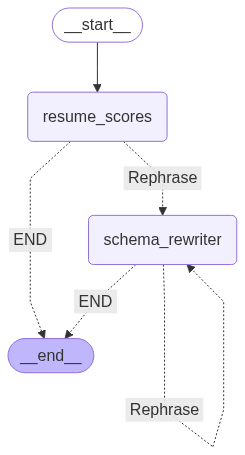

In [34]:
compiledGraph

In [33]:
result

NameError: name 'result' is not defined

In [21]:
invalid_response = """score 65,
  items 'Quantify your achievements with metrics. Instead of describing tasks (e.g., "Fine-tuned model responses"), state the impact (e.g., "Improved chatbot response accuracy by 20% by implementing a RAG framework"). This is the most critical improvement needed.'
   'Adopt a standard, single-column resume format. The current two-column layout is broken, causing formatting errors (e.g., "gmail.c om", "B .Tech.") and making the resume difficult to read for both humans and applicant tracking systems (ATS).'
   'Strengthen your bullet points by using more powerful action verbs and focusing on outcomes. Replace vague phrases like "Helped in finding out issues" with specific accomplishments like "Identified 15+ critical bugs, leading to a 10% reduction in customer support tickets."'
   'Rename the main "PROJECTS" section to "PROFESSIONAL EXPERIENCE". The current title is confusing because it lists your employment history, not just standalone projects.'
   'Streamline the Education section by removing your 10th and 12th-grade results. For an experienced professional, only university-level degrees are relevant.'
   'Remove the "PERSONAL DETAILS" and "HOBBIES" sections. Information like your date of birth is unnecessary and can introduce bias. Hobbies like "Friends Catchup" are unprofessional. Use the space to elaborate on your project impacts.'
   'Refine your professional summary. The current one is generic. Start with a stronger statement that highlights your years of experience and key specializations, e.g., "Data Scientist with 5+ years of experience specializing in Generative AI and predictive modeling for the telecom and finance industries."
   """


#sample_result = rewriter_chain.invoke({"invalid_response": invalid_response})

In [54]:
result

{'resumeString': '\nketan.kishore31@gmail.c  om  +91 7488391342  House No. 4098, Sector   –  4/F, Bokaro Steel City,  Jharkhand   -   827004  EDUCATION  10th from Delhi Public  School, Bokaro Steel City,  Jharkhand in 2010 with  95% GPA  12 th   from Delhi Public  School, Bokaro Steel City,  Jharkhand in 2013 with  82% GPA  B .Tech. in Electronics and  Communication from SRM  University, Chennai in 2017  with 76.85 GPA  M.Tech in Data Science and  Engineering from BITS   -  Work Integrated, 2023 with  7.27 CGPA  Ketan Kishore  An enthusiastic & high energy driven professional ,   targeting challenging assignments as a   Data  Scientist   with an organization of high repute .  GitHub Repo:   https://github.com/ketankishore27  Docker Hub Repo:   https://hub.docker.com/u/ketankishore27  LinkedIn :   https://www.linkedin.com/in/ketan - kishore - b89643150/  PROFILE SUMMARY  •   Goal - oriented professional with experience in   Insurance ,   Banking , and   Telecom   domains.  •   Skilled i

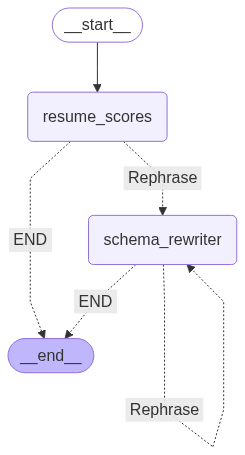

In [42]:
#compiledGraph

In [43]:
#compiledGraph.invoke({"resume": resume_string, "job_role": jobRole})

dict_keys(['resumeString', 'initial_response', 'jobRole', 'scratchpad'])


KeyError: 'repeat'

In [ ]:
result['initial_response']

In [ ]:
result.keys()

In [64]:
node_resume_scores(resumeText = resume_string, jobRole = jobRole)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


{'score': 65,
 'items': ['Quantify your achievements with metrics. Instead of describing tasks (e.g., "Fine-tuned model responses"), state the impact (e.g., "Improved chatbot response accuracy by 20% by implementing a RAG framework"). This is the most critical improvement needed.',
  'Adopt a standard, single-column resume format. The current two-column layout is broken, causing formatting errors (e.g., "gmail.c om", "B .Tech.") and making the resume difficult to read for both humans and applicant tracking systems (ATS).',
  'Strengthen your bullet points by using more powerful action verbs and focusing on outcomes. Replace vague phrases like "Helped in finding out issues" with specific accomplishments like "Identified 15+ critical bugs, leading to a 10% reduction in customer support tickets."',
  'Rename the main "PROJECTS" section to "PROFESSIONAL EXPERIENCE". The current title is confusing because it lists your employment history, not just standalone projects.',
  'Streamline the Ed

In [4]:
class ResumeScore(BaseModel):

    score: int = Field("Overall score of the resume, an Applicant Tracking System would give to the resume.")

In [5]:
output_format = PydanticOutputParser(pydantic_object = ResumeScore).get_format_instructions()

In [63]:
jobRole = "Data Scientist"
resume_string = """
ketan.kishore31@gmail.c  om  +91 7488391342  House No. 4098, Sector   –  4/F, Bokaro Steel City,  Jharkhand   -   827004  EDUCATION  10th from Delhi Public  School, Bokaro Steel City,  Jharkhand in 2010 with  95% GPA  12 th   from Delhi Public  School, Bokaro Steel City,  Jharkhand in 2013 with  82% GPA  B .Tech. in Electronics and  Communication from SRM  University, Chennai in 2017  with 76.85 GPA  M.Tech in Data Science and  Engineering from BITS   -  Work Integrated, 2023 with  7.27 CGPA  Ketan Kishore  An enthusiastic & high energy driven professional ,   targeting challenging assignments as a   Data  Scientist   with an organization of high repute .  GitHub Repo:   https://github.com/ketankishore27  Docker Hub Repo:   https://hub.docker.com/u/ketankishore27  LinkedIn :   https://www.linkedin.com/in/ketan - kishore - b89643150/  PROFILE SUMMARY  •   Goal - oriented professional with experience in   Insurance ,   Banking , and   Telecom   domains.  •   Skilled in   Predictive Modeling   using   Supervised   and   Unsupervised   Learning  •   E xperienced in   Text   Analytics   using   NLP , LLM   and   Generative AI  •   Exposure   to   Cloud services like   AWS   and   Azure  •   Proficient   in working with   Distributed Framework   for   scalable   Analytics and Modelling  PROJECTS  T - Systems India Pvt Ltd   Apr’21   –   Present  Client:   Deutsche Telekom (Germany)  Common Service Desk   (Generative AI)  •   Partnered with stakeholders to define clear project goals and success criteria .  •   Designed and implemented backend models for service desk   support   using RASA and RAG .  •   Fine - tuned model responses to enhance accuracy and   user experience .  •   Created   APIs   for real - time AI model integration .  •   Analysis for incorrect responses from the chatbot.  Client:   Deutsche   Telekom   ( Germany,   Croatia , Hungary , Poland )  Router Domain   (Machine Learning, Big Data)  •   Feature store for telecom data .  •   Developed   models to predict   issues   like   Device, I nstallation , Line, Wi - Fi   error etc.  •   D ashboards   for the bootstrapped new router   developed by   organization .  •   Created flows to   troubleshoot and find new issues in new router versions.  •   Developed customer profiling and journey analysis for people visiting our app.  •   Helped in   finding out issues in the Deutsche Telecom `My Magenta` app  Bajaj Finance   Jun ’ 20   –   Apr’21  Client: Loans /Lending   Team  Money Manager   (Machine Learning)  •   Created ML model to   classify   transactional message   and store entities  •   Assisting   in creating real time offer generation pipeline based on above extracted entities  Client: E - Store   Team  Nearest Dealer Solution   (Machine Learning)  •   Created a   ML model to identify   nearest dealers   for   visitors   on the website.  •   Incorporated business rules to recommend dealers based on loyalty, reviews/score and distance  Client: Marketing   + Cards Team  Clickstream Analytics   (Adobe Analytics, Big Data)  •   Created reports on   Adobe Analytics   on Customer Journey, Path, Churn and Anomaly  •   A nalyze and   r ecommend concordan t /discordan t   simulations sent to the identified visitors
PERSONAL DETAILS  Date of Birth: 20 th   February 1995  Lan guages Known: English and Hindi  HOBBIES  •   Travel  •   Cook  •   Gym  •   Personal Projects ( Here )  •   Friends Catchup  Capgemini.   Oct ’ 17   -   Jun ’20  Client:   Swiss Re  Trip Optimization   -   POC (Tableau, Statistical Modelling)  •   Developed a constrained   algorithm   to optimize trip allocation   cost .  •   Implemented hierarchical de - allocation of trips consi dering corporate band and real time  Tableau frontend filters  •   Created and presented   dashboard having   Drill Down Reports   and overall summary  Client:   Sunlife Financials  News - Feed   –   POC   (N atural   L anguage   P rocessing , Web Scraping)  •   Developed a web crawler   to search   the web   and perform NLP task to create insights.  •   Worked   on possibility to use   satellite imagery to predict Catastrophes damage index .  Client:   Assurant Employee Benefits  Analytics   and Automation   (Python, Basic Machine Learning)  •   Analyze ,   Visualize,   and deduce KPI based on claims distributed over geographical area.  •   Implemented ML and DL model to predict   Fraudulent/Incorrect C laims  •   Work ed   parallel   on   development of   Churn Model   ( POC ).  •   Created   Python API’s and Selenium automations
"""

instruction_prompt = """
You are a hiring manager and resume reviewer with 10+ years of experience in talent acquisition and human resource management.

Your task is to critically evaluate a candidate's resume and provide the following outputs:

1. **Score (out of 100)** — based on overall quality, clarity, relevance, structure.

---

### Evaluation Criteria:
- Clarity and conciseness of content
- Structure and formatting
- Use of metrics and accomplishments
- Language quality (grammar, tone, consistency)

---

**Candidate Resume**:
{resume}

{format_instructions}
"""

In [36]:
scoring_prompt = PromptTemplate.from_template(template=instruction_prompt, 
                                              partial_variables = {"format_instructions": output_format})

In [40]:
chain = scoring_prompt | llm | JsonOutputParser()

In [41]:
result = chain.invoke({"resume": resume_string})

In [42]:
result

{'score': 58}